# Introduction
The goal of these notebooks is to replicate how SimCLR works. The present notebook follows the primary notebook that was created and uses the imagenet dataset. 

The WandB reports have been added to the repository seperately. 

# Initial setup

In [ ]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
!nvidia-smi

Wed Nov 24 05:55:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

# Dataset gathering and preparation
The imagenet dataset has been sampled with 5 categories and seperated into training and testing 

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 32.42 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [ ]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [ ]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

100%|██████████| 1250/1250 [00:05<00:00, 214.85it/s]


(1250, 224, 224, 3) (1250,)


100%|██████████| 250/250 [00:01<00:00, 224.64it/s]


(250, 224, 224, 3) (250,)


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
# Set up TensorFlow dataset for performance optimization
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_enc))
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Utilities

In [ ]:
# Architecture utils
def get_resnet():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    
    inputs = Input((224, 224, 3))
    features = base_model(inputs, training=False)
    pooled_features = GlobalAveragePooling2D()(features)

    pooled_features = Dense(256)(pooled_features)
    pooled_features = Activation("relu")(pooled_features)
    outputs = Dense(5, activation="softmax")(pooled_features)

    resnet_simclr = Model(inputs, outputs)

    return resnet_simclr

In [ ]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

# Training

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [ ]:
get_resnet().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                             

In [ ]:
# Train the supervised model with full data
wandb.init(project="simclr", id="supervised-training")

model = get_resnet()
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(1e-3))
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[es, WandbCallback()])

wandb: Wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Streaming file created twice in same run: /content/wandb/run-20211124_055737-supervised-training/wandb-events.jsonl
Streaming file created twice in same run: /content/wandb/run-20211124_055737-supervised-training/wandb-history.jsonl


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.7169 - accuracy: 0.1848

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


20/20 [==============================] - 16s 561ms/step - loss: 1.7169 - accuracy: 0.1848 - val_loss: 1.6100 - val_accuracy: 0.2000
Epoch 2/50
20/20 [==============================] - 9s 463ms/step - loss: 1.6109 - accuracy: 0.1904 - val_loss: 1.6068 - val_accuracy: 0.3240
Epoch 3/50
20/20 [==============================] - 8s 397ms/step - loss: 1.6005 - accuracy: 0.2064 - val_loss: 1.6081 - val_accuracy: 0.2000
Epoch 4/50
20/20 [==============================] - 8s 400ms/step - loss: 1.6105 - accuracy: 0.2056 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 00004: early stopping


# Epoch-wise Accuracy

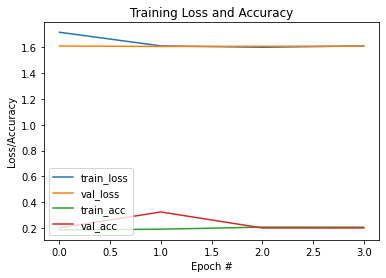

In [ ]:
plot_training(history)